In [2]:
#Imports Bildverarbeitung
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
def plot1(image, title="debugging"):
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def plot(image, title='debugging'):
    l = len(image.shape)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.imshow(image, cmap='gray' if l == 2 else None)
    plt.axis('off')
    plt.show()

In [4]:
import os
from os import path
dir = "Bilder/handy"
def filecheck(fn):
    return path.isfile(path.join(dir, fn)) and fn.startswith('sodoku')
image_filenames = [fn for fn in os.listdir("Bilder/handy") if filecheck(fn)]

def read_img(image_path):
    return cv2.imread(image_path, -1)

image_map = [[fn, read_img(path.join(dir,fn))] for fn in image_filenames]

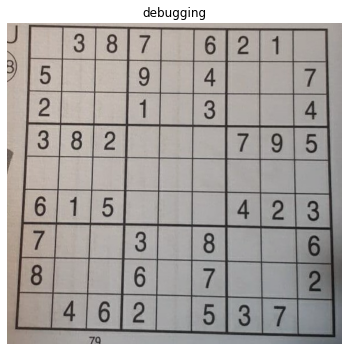

In [5]:
plot(image_map[0][1])

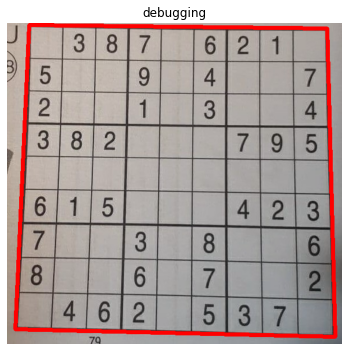

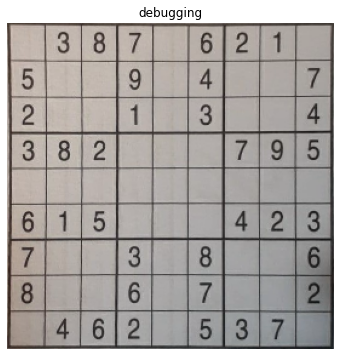

In [6]:
## Sodoku erkennen
def warping(image): 
    # Kantendetektion mit Canny
    canny_output = cv2.Canny(image, 90, 200)
    # Konturenfilterung anhand der berechneten Kanten
    #TODO algorithmus recherchieren opencv
    contours, _ = cv2.findContours(canny_output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    # cv2.RETR_TREE --> alle gefundenen Konturen werden gespeichert
    # cv2.CHAIN_APPROX_SIMPLE --> nur die Punkte von den Ecken werden gespeichert (mehrere, nicht nur vier, aber an den vier Ecken)

    # größtes rechteck finden
    max_area_index, max_contour = max(enumerate(contours), key=lambda i_image: cv2.contourArea(i_image[1]))

    # Koordinaten der Eckpunkte ermitteln quelle: https://www.geeksforgeeks.org/find-co-ordinates-of-contours-using-opencv-python/
    approx = cv2.approxPolyDP(max_contour, 0.009 * cv2.arcLength(max_contour, True), True)
    #Plot 
    image_copy = np.copy(image)
    cv2.drawContours(image_copy, [approx], 0, (255, 0, 0), 5) 
    plot(image_copy)

    # Bild perspektivisch verändern und zuschneiden quelle: https://www.pyimagesearch.com/2014/05/05/building-pokedex-python-opencv-perspective-warping-step-5-6/
    points = approx.reshape(4,2)
    rect = np.zeros((4, 2), dtype = "float32")

    summe = points.sum(axis = 1)
    rect[0] = points[np.argmin(summe)] #oben_links
    rect[2] = points[np.argmax(summe)] #unten_rechts
    differenz = np.diff(points, axis = 1)
    rect[1] = points[np.argmin(differenz)] #oben_rechts
    rect[3] = points[np.argmax(differenz)] #unten_links

    maxWidth = 270
    maxHeight = maxWidth

    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warp

warp = warping(image_map[0][1])
plot(warp)

In [7]:
def create2Darray(x,y):
    return [[0 for i in range(x)] for j in range(y)]
def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

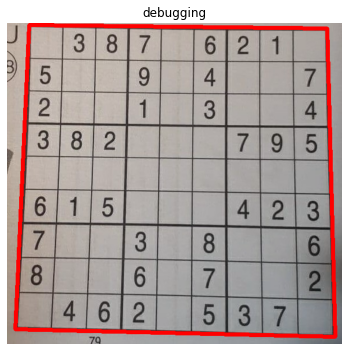

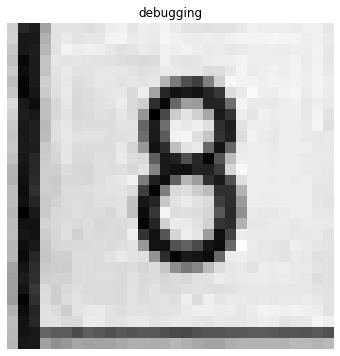

In [8]:
def cut_to_9x9(image):
    img = image if len(image.shape) == 2 else to_gray(image)
    w,h = img.shape
    sub_w, sub_h = int(w/9), int(h/9)
    subimages = create2Darray(9,9)
    for y in range(9):
        for x in range(9):
            subimages[y][x] = img[sub_h*y:sub_h*(y+1), sub_w*x:sub_w*(x+1)]
    return subimages
plot(cut_to_9x9(warping(image_map[0][1]))[7][0])

In [10]:
def draw_sudoku(sudoku_numbers):
    # [x][y]
    fig, ax = plt.subplots(figsize=(6, 6))

    for x, column in enumerate(sudoku_numbers):
        for y, n in enumerate(column):
            #plt.text(x,y,str(n))
            ax.text(x+.35, y+.35, str(n), color="black", fontsize=16)
    for x in range(10):
        ax.plot((0,9),(x,x), color="black", linewidth='.3' if x % 3 else '.9')
    for y in range(10):
        ax.plot((y,y),(0,9), color="black", linewidth='.3' if y % 3 else '.9')
    plt.axis('off')
    plt.show(x)

In [85]:
# load single number images
traindata = {}
traindata_path = 'Ziffern'
foldernames = os.listdir(traindata_path)
for foldername in foldernames:
    traindata[foldername] = []
    for fn in os.listdir(path.join(traindata_path, foldername)):
        fullfn = path.join(path.join(traindata_path, foldername), fn) # pfade sicher konkatenieren
        if path.isfile(fullfn):
            label = [0]*10
            label[int(foldername)] = 1
            traindata[foldername] += [[read_img(fullfn), label]]

In [86]:
traindata['5'][1][1]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [87]:
# transform data
target = []
input = []
for _, image_label_list in traindata.items():
    for (image, out) in image_label_list:
        w,h = image.shape
        input += [ image.reshape(w*h) ]
        target += [ out ]


In [88]:
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(100,50), random_state=1, max_iter=10000, learning_rate_init=0.001, verbose=True, early_stopping=False,  n_iter_no_change=30 )
clf.fit(input, target)

Iteration 1, loss = 101.07507402
Iteration 2, loss = 39.59364176
Iteration 3, loss = 37.75035741
Iteration 4, loss = 33.58605207
Iteration 5, loss = 28.09842741
Iteration 6, loss = 26.09322302
Iteration 7, loss = 23.05598639
Iteration 8, loss = 23.26415869
Iteration 9, loss = 24.05011316
Iteration 10, loss = 20.44473251
Iteration 11, loss = 18.83322415
Iteration 12, loss = 17.04590558
Iteration 13, loss = 15.99146493
Iteration 14, loss = 16.41086348
Iteration 15, loss = 16.35746573
Iteration 16, loss = 16.27200726
Iteration 17, loss = 15.76114952
Iteration 18, loss = 12.68947895
Iteration 19, loss = 13.23092614
Iteration 20, loss = 13.14404714
Iteration 21, loss = 12.10887183
Iteration 22, loss = 11.57871890
Iteration 23, loss = 10.98815385
Iteration 24, loss = 9.58378607
Iteration 25, loss = 10.20541752
Iteration 26, loss = 10.60390204
Iteration 27, loss = 9.02638806
Iteration 28, loss = 9.07830301
Iteration 29, loss = 8.51901312
Iteration 30, loss = 8.76768795
Iteration 31, loss = 8.

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(100, 50), max_iter=10000,
              n_iter_no_change=30, random_state=1, verbose=True)

In [89]:
clf.predict([input[10]])

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [116]:
def detect_number(image):
    # neuronales netz
    w,h = image.shape
    # return int(random.random()*10)
    resized_image = cv2.resize(image,(30,30)).reshape(30*30)
    #plot(resized_image.reshape(30,30))
    label = clf.predict([resized_image])
    label_list = list(label)
    return label_list.index(max(label_list))

def detect_numbers(sub_images):
    numbers = create2Darray(9,9)
    for y, column in enumerate(sub_images):
        for x, sub_images in enumerate(column):
            numbers[x][y] = detect_number(sub_images)
    return numbers

In [92]:
test_image_dir = '44x44'
testimages = []
filenames = os.listdir(test_image_dir)
for fn in filenames:
    image = read_img(path.join(test_image_dir, fn))
    testimages += [ cv2.resize(image, [30,30]).reshape(30*30) ]

In [111]:
#print()
#plot(testimages[4].reshape(30,30))

labels = clf.predict(testimages)
for i, (testimage, label) in enumerate(zip(testimages, labels)):
    label_list = list(label)
    foldername = str(label_list.index(max(label_list)))
    try:
        os.makedirs('test/'+foldername+'/')
    except:
        pass #print('folder exists')
    cv2.imwrite('test/'+foldername+'/im-'+str(i)+'.png', testimage.reshape(30,30))

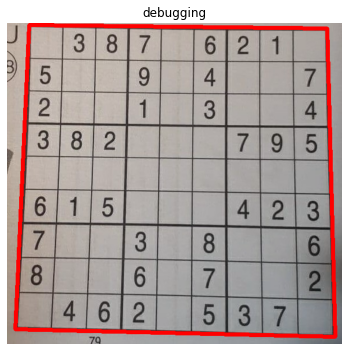

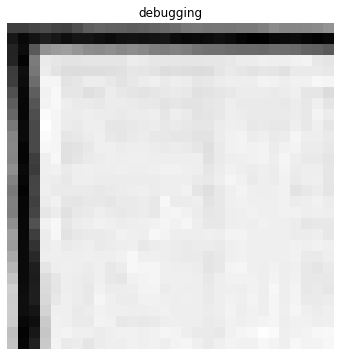

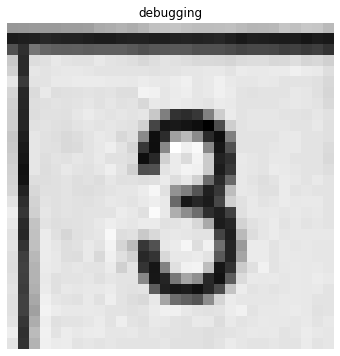

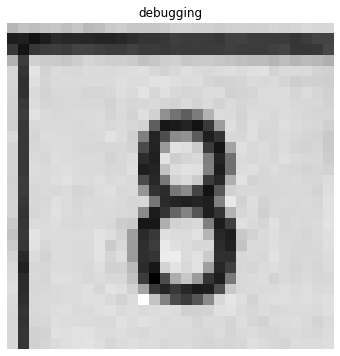

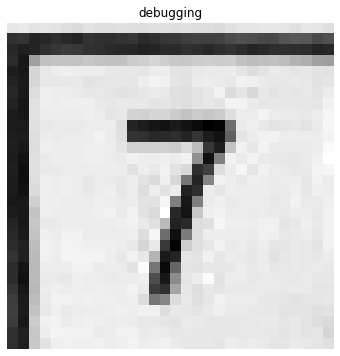

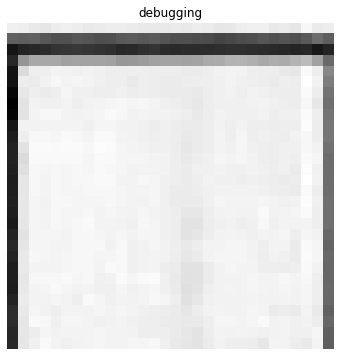

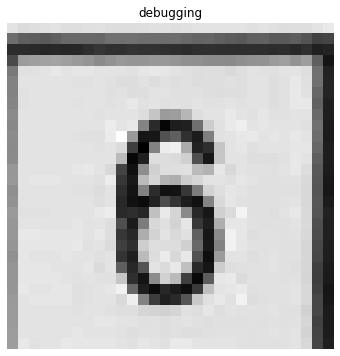

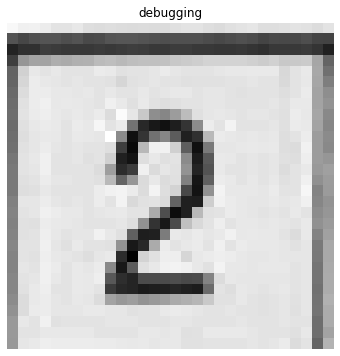

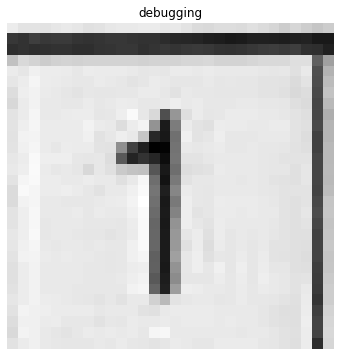

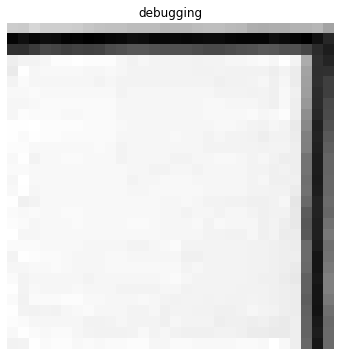

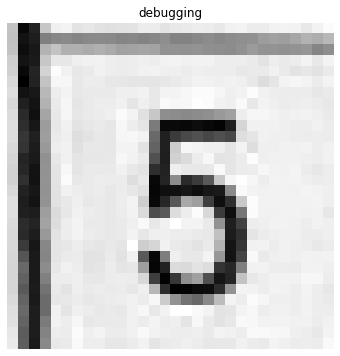

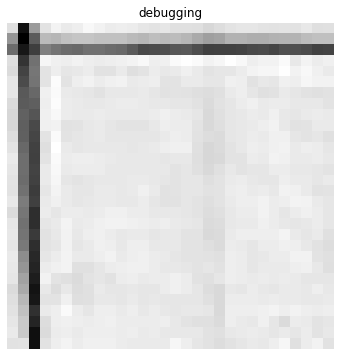

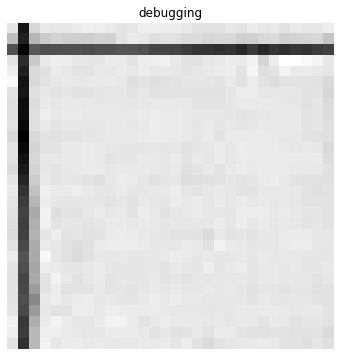

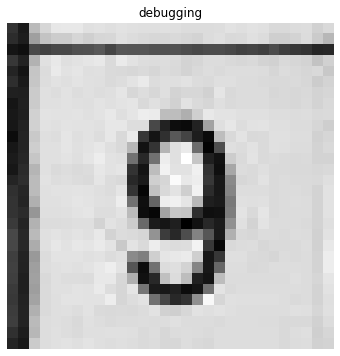

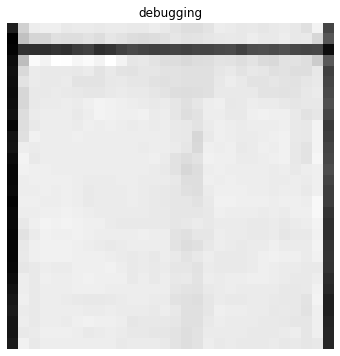

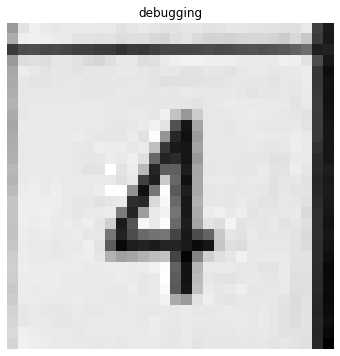

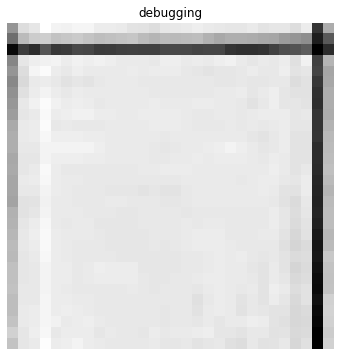

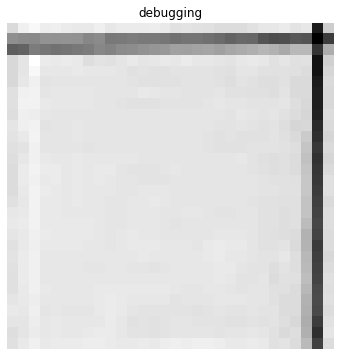

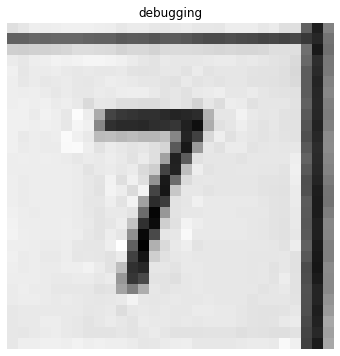

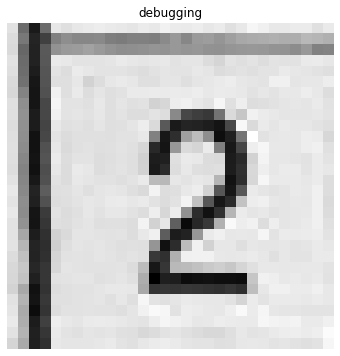

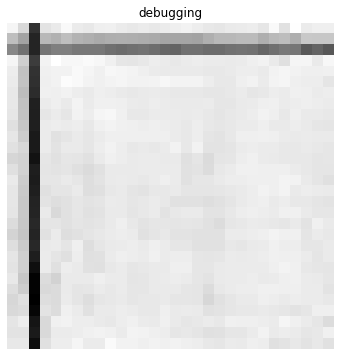

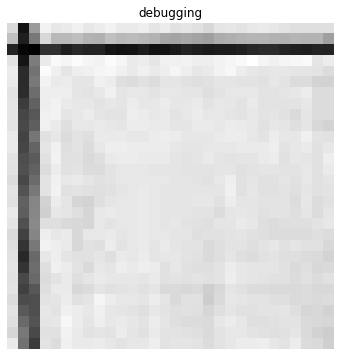

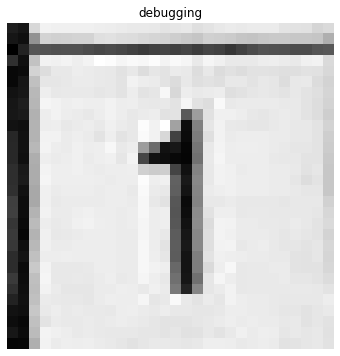

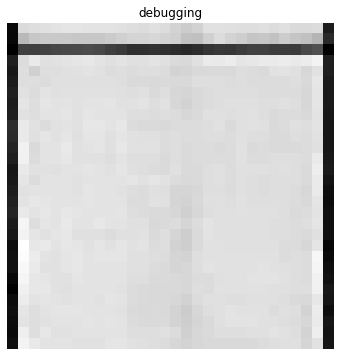

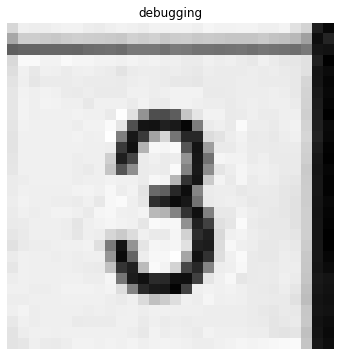

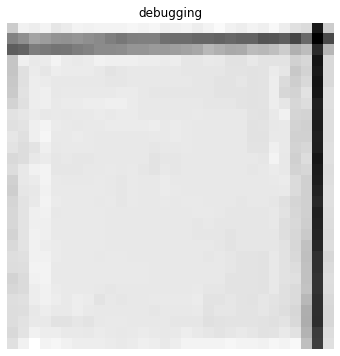

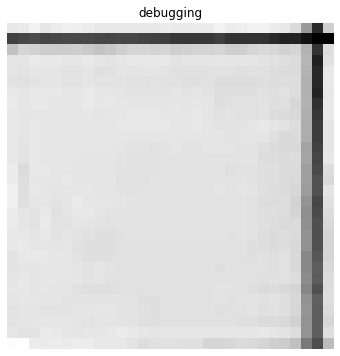

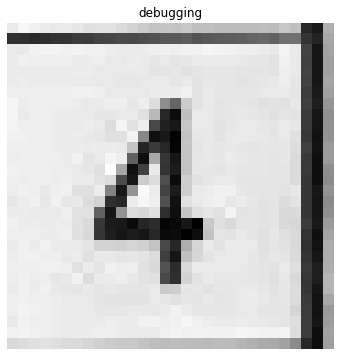

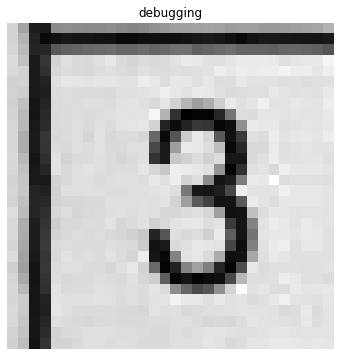

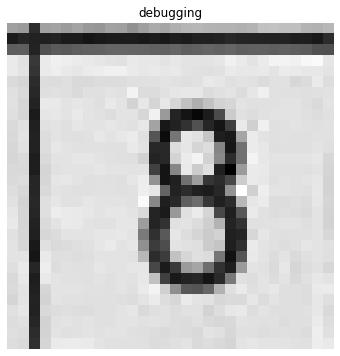

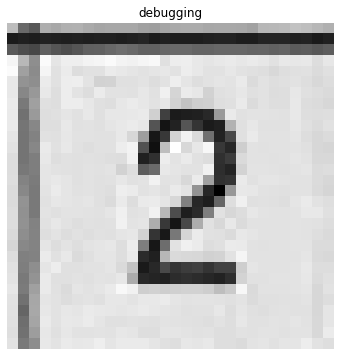

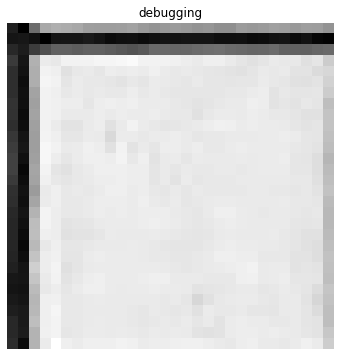

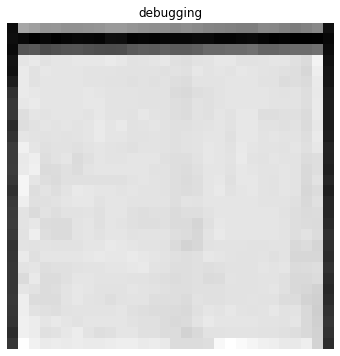

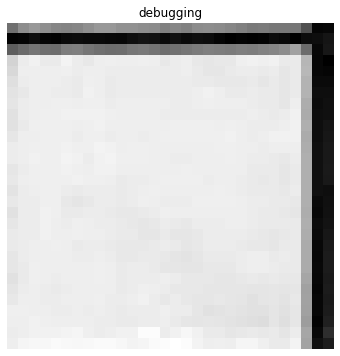

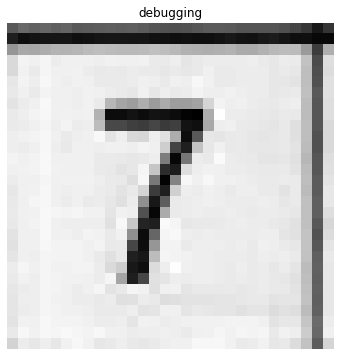

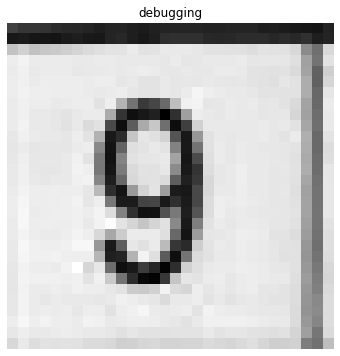

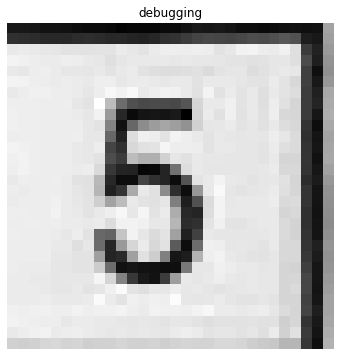

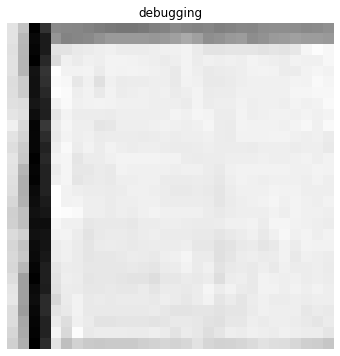

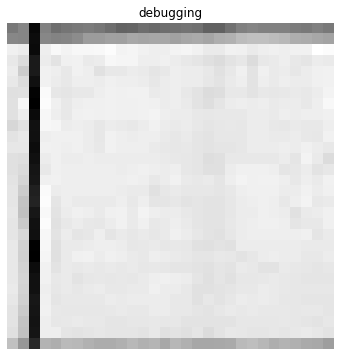

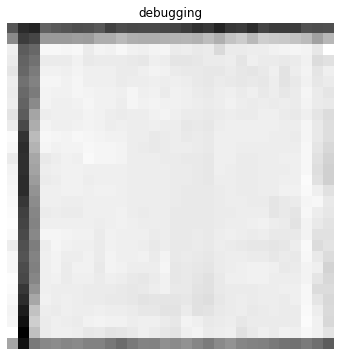

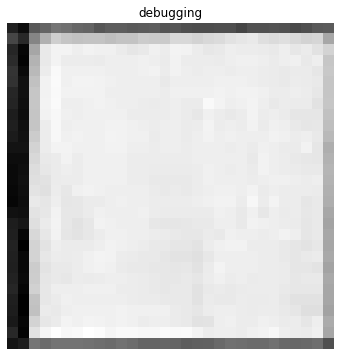

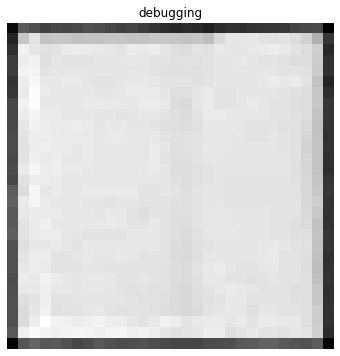

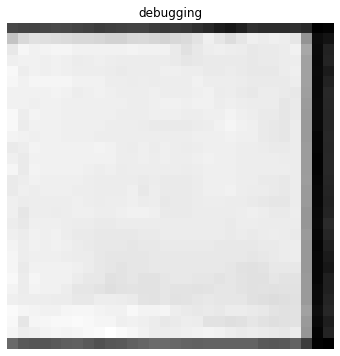

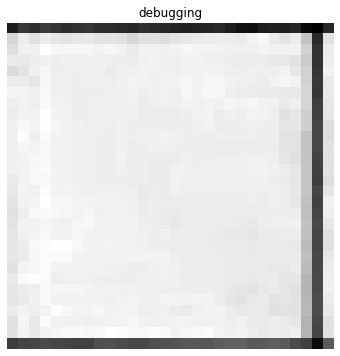

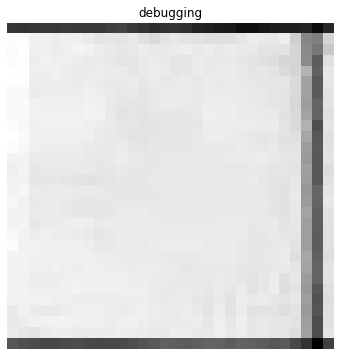

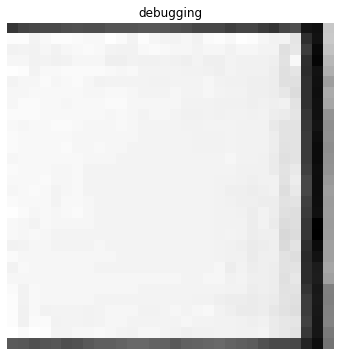

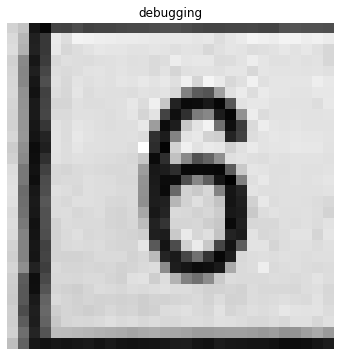

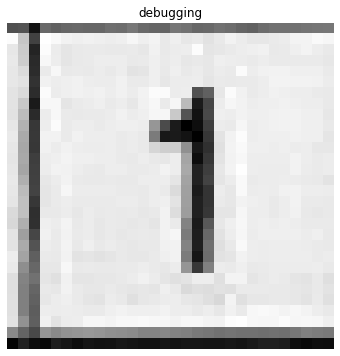

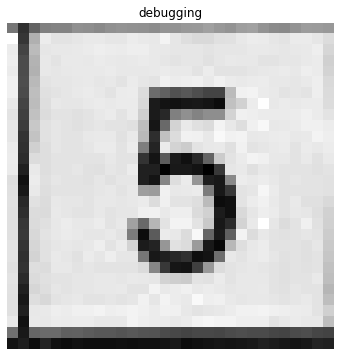

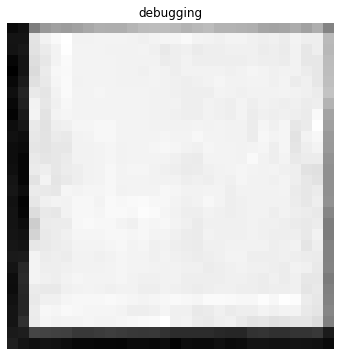

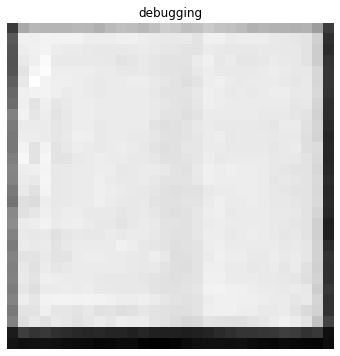

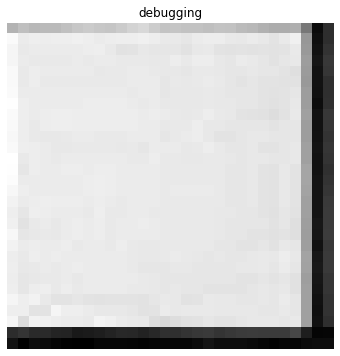

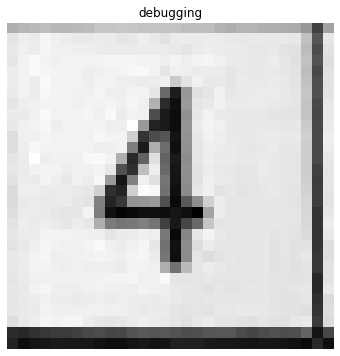

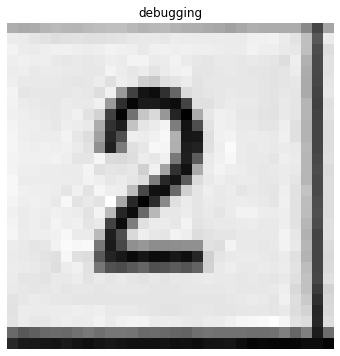

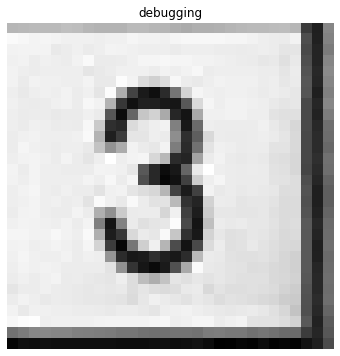

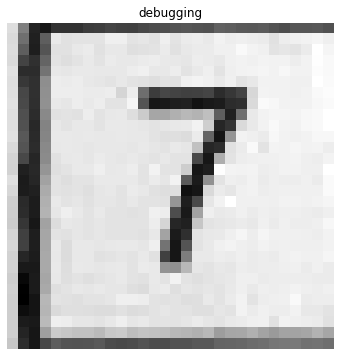

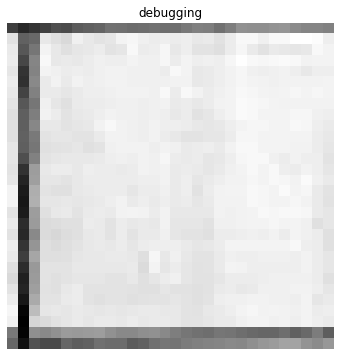

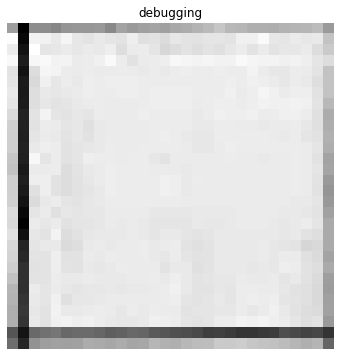

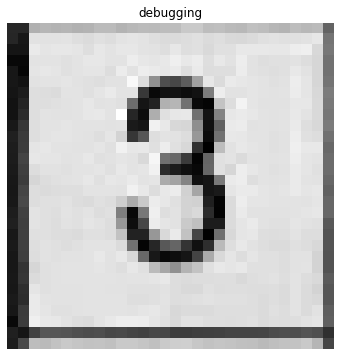

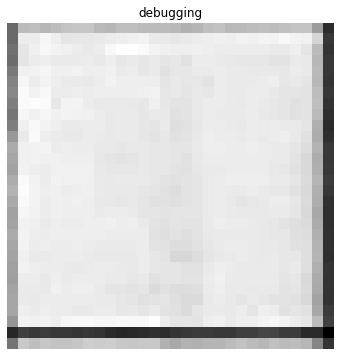

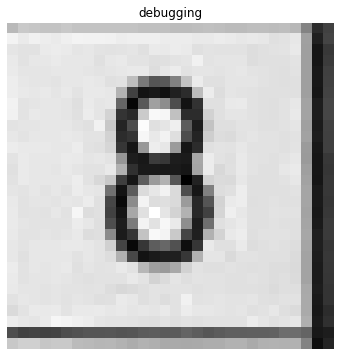

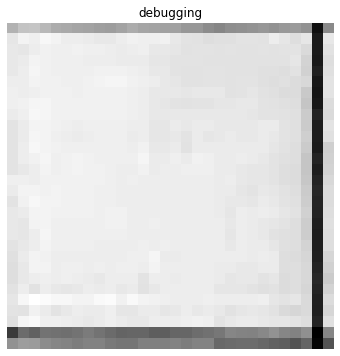

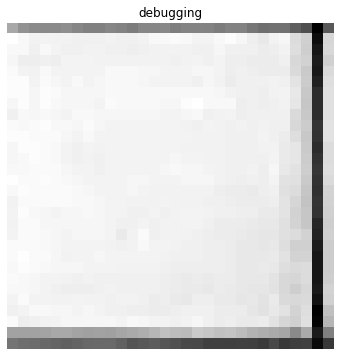

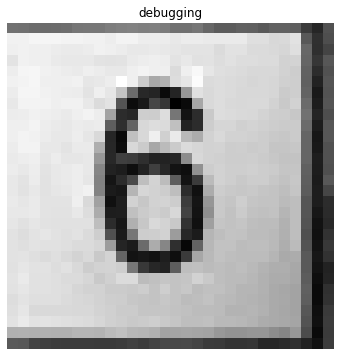

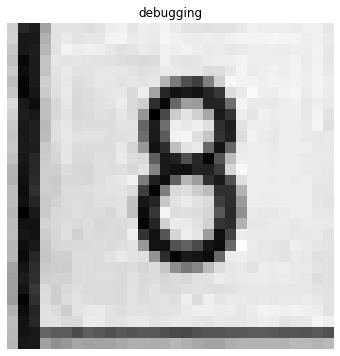

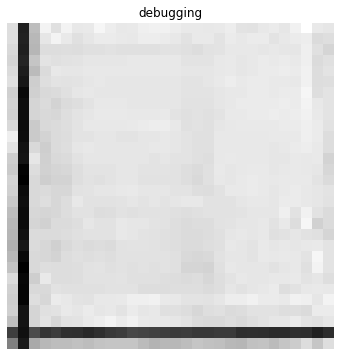

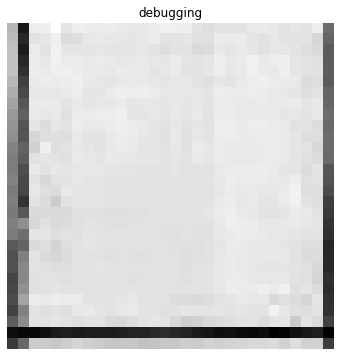

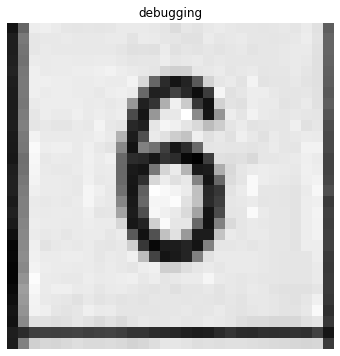

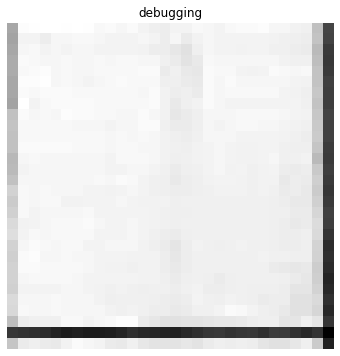

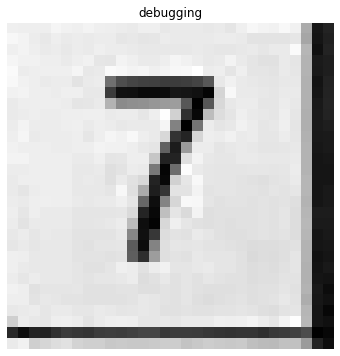

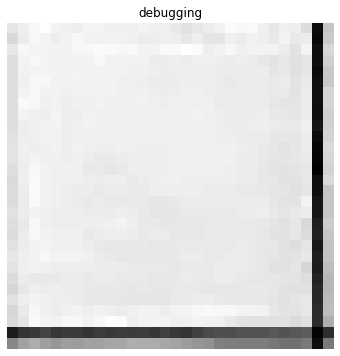

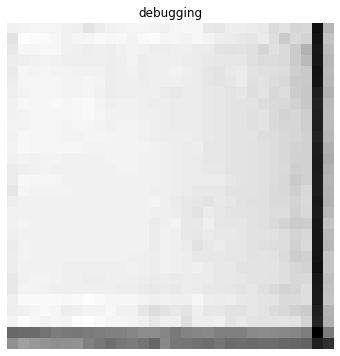

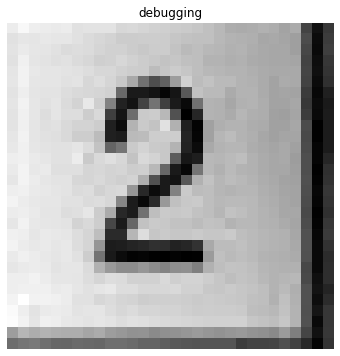

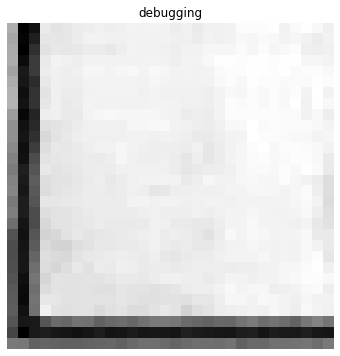

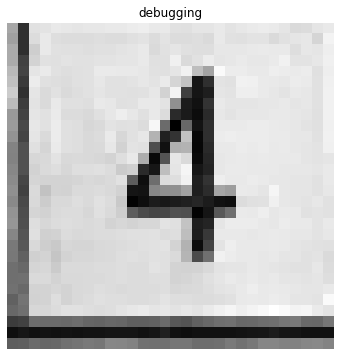

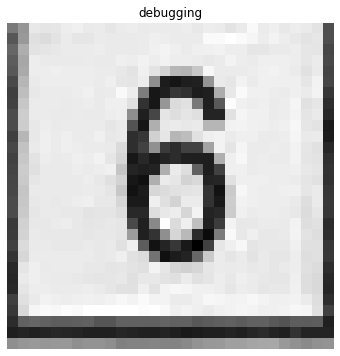

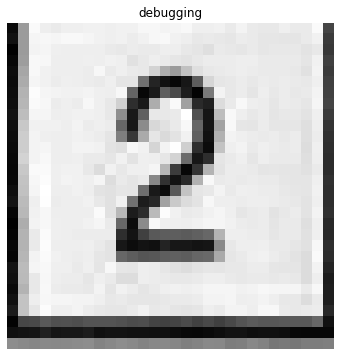

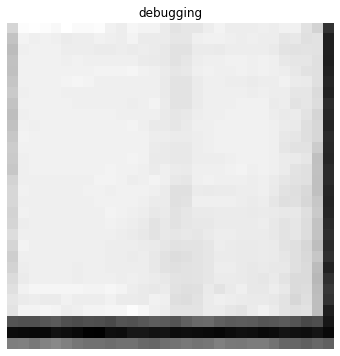

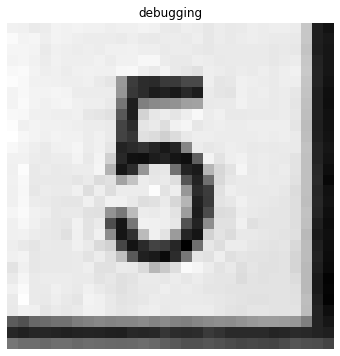

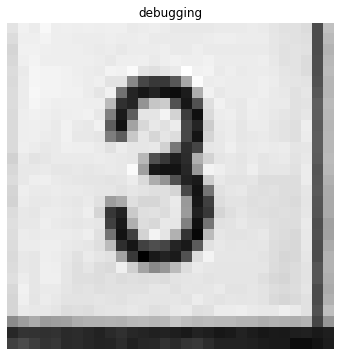

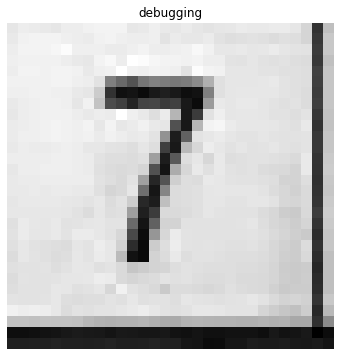

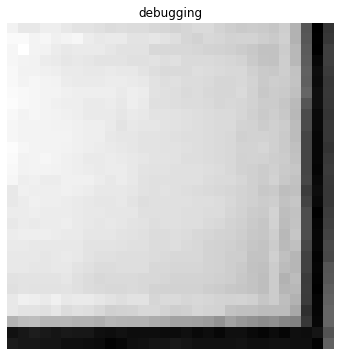

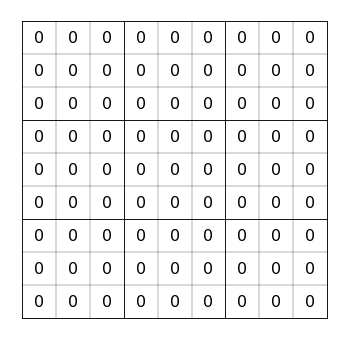

NameError: name 'solved_sudoku' is not defined

In [117]:
# full processing pipeline:

image = image_map[0][1]
warped = warping(image)
sub_images = cut_to_9x9(warped)
sudoku_numbers = detect_numbers(sub_images)
draw_sudoku(sudoku_numbers)
solved_numbers = solved_sudoku(sudoku_numbers)
draw_sudoku(solved_numbers)